Import all identifications from GNPS (from 100 files or so) and "clean up" the table

In [2]:
import pandas as pd
import numpy as np

In [50]:
df= pd.read_csv("resources/MS2_LIBRARYSEARCH_all_identifications_cos0_7.tsv", sep='\t', encoding='latin-1')
df.drop(df.index[df['IonMode'] == "negative"], inplace=True)
df.drop(df.index[df['MZErrorPPM'] > 20.0], inplace=True)
GNPS=df.drop(columns=["PI", "Adduct", "IonMode", "Organism", "MZErrorPPM", "SpecMZ"])
GNPS=GNPS.rename(columns= {"RT_Query": "RetentionTime"})
GNPS=GNPS.drop_duplicates(subset="Compound_Name", keep='first')
GNPS

,Compound_Name,Precursor_MZ,RetentionTime
0,dehydroxynocardamine,585.361000,347.70300
2,Massbank:PR311142 Cyclo(leucylprolyl),211.144000,200.44700
6,cyclo(L-Val-L-Pro),197.129000,311.23700
8,"""(4R)-4-((3R,5R,6S,7R,9S,10R,12S,13R,17R)-3,6,...",871.554000,419.38900
9,Massbank:PR300821 Cyclo(proline-leucine),211.144000,223.96100
...,...,...,...
356761,Spectral Match to Tyr-Ala from NIST14,253.118000,76.97570
357126,epemicinA,793.446100,412.72450
357127,epemicinB,712.420400,405.53937
357128,"epemicinB, M+H",1423.832300,405.53937


Import the feature matrix

In [5]:
Features= pd.read_csv("results/Requant/FeatureMatrix.tsv", sep="\t")
Features= Features.drop(columns="charge")
Features.columns= [col.replace( r'MDNAWGS', 'MDNA_WGS_') for col in Features.columns]
Features= Features.sort_index(axis=1)
Features.columns = Features.columns.str.replace(r'_Plate-\d', '')
Features= Features.astype(float)
cols= Features.columns
Features

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_5190/1304035001.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  Features.columns = Features.columns.str.replace(r'_Plate-\d', '')


,DNPM_MDNA_WGS_14_blank,DNPM_MDNA_WGS_14_rep1,DNPM_MDNA_WGS_14_rep2,DNPM_MDNA_WGS_14_rep3,FPY12_MDNA_WGS_14_blank,FPY12_MDNA_WGS_14_rep1,FPY12_MDNA_WGS_14_rep2,FPY12_MDNA_WGS_14_rep3,ISP2_MDNA_WGS_14_blank,ISP2_MDNA_WGS_14_rep1,ISP2_MDNA_WGS_14_rep2,ISP2_MDNA_WGS_14_rep3,RT,mz
0,652974.2,256839.50,151520.20,79780.14,36973.93,628200.2,339779.6,247363.30,156607.50,130316.80,83421.75,138740.0000,310.646900,489.25494
1,191643.6,86121.01,158938.70,118689.00,210583.50,650682.9,902076.1,1102605.00,79279.17,32975.19,26509.98,46461.7000,297.140900,396.18720
2,2042334.0,38741.71,10947.06,13384.05,36551.81,187921.5,117213.5,180031.00,189583.80,59839.03,40146.67,34080.9500,94.086006,359.23950
3,2365180.0,2259782.00,1784322.00,1825069.00,67544.91,412922.4,45230.8,63598.06,561391.30,373302.30,315790.40,306980.4000,161.530620,308.17114
4,123069.0,913240.10,786868.00,752350.00,1438382.00,152461.8,234744.9,405019.70,1170589.00,729176.80,671625.10,642311.7000,334.723360,239.13843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9118,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,5291.9917,372.089800,729.37490
9119,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,5563.9210,73.231750,641.36120
9120,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,4165.5845,266.885350,684.33820
9121,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,6572.3530,294.532650,868.39465


Annotate the features detected by GNPS according to mz and RT (mz tolerance 10 ppm and RT tolerance 20 seconds)

In [6]:
Features.insert(0, 'GNPS_IDs', '')

for i, mz, rt in zip(Features.index, Features['mz'], Features['RT']):
    hits = []
    for name, GNPS_mz, GNPS_rt, in zip(GNPS['Compound_Name'], GNPS['Precursor_MZ'], GNPS['RetentionTime']):
        mass_delta = (abs(GNPS_mz-mz)/GNPS_mz)*1000000.0 if GNPS_mz != 0 else 0
        if (GNPS_rt >= rt-20.0) & (GNPS_rt <= rt+20.0) & (mass_delta<= 20.0):
            hit = f'{name}'
            if hit not in hits:
                hits.append(hit)
    Features['GNPS_IDs'][i] = ' ## '.join(hits)

Features.to_csv("results/annotations/GNPS_annotated_feature_matrix.tsv", sep='\t', index = False)
Features

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_5190/1724528735.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Features['GNPS_IDs'][i] = ' ## '.join(hits)


,GNPS_IDs,DNPM_MDNA_WGS_14_blank,DNPM_MDNA_WGS_14_rep1,DNPM_MDNA_WGS_14_rep2,DNPM_MDNA_WGS_14_rep3,FPY12_MDNA_WGS_14_blank,FPY12_MDNA_WGS_14_rep1,FPY12_MDNA_WGS_14_rep2,FPY12_MDNA_WGS_14_rep3,ISP2_MDNA_WGS_14_blank,ISP2_MDNA_WGS_14_rep1,ISP2_MDNA_WGS_14_rep2,ISP2_MDNA_WGS_14_rep3,RT,mz
0,,652974.2,256839.50,151520.20,79780.14,36973.93,628200.2,339779.6,247363.30,156607.50,130316.80,83421.75,138740.0000,310.646900,489.25494
1,,191643.6,86121.01,158938.70,118689.00,210583.50,650682.9,902076.1,1102605.00,79279.17,32975.19,26509.98,46461.7000,297.140900,396.18720
2,,2042334.0,38741.71,10947.06,13384.05,36551.81,187921.5,117213.5,180031.00,189583.80,59839.03,40146.67,34080.9500,94.086006,359.23950
3,,2365180.0,2259782.00,1784322.00,1825069.00,67544.91,412922.4,45230.8,63598.06,561391.30,373302.30,315790.40,306980.4000,161.530620,308.17114
4,,123069.0,913240.10,786868.00,752350.00,1438382.00,152461.8,234744.9,405019.70,1170589.00,729176.80,671625.10,642311.7000,334.723360,239.13843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9118,,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,5291.9917,372.089800,729.37490
9119,,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,5563.9210,73.231750,641.36120
9120,,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,4165.5845,266.885350,684.33820
9121,,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,6572.3530,294.532650,868.39465


Keep the unannotated features only and drop the features detected in the negative controls

In [7]:
Matrix= Features[Features.GNPS_IDs == '']
blanks= Matrix.filter(regex=fr"blank") 
cols= blanks.columns
for col in cols:
    Matrix= Matrix.drop(Matrix.index[Matrix[col] != 0].tolist())
Matrix= Matrix.drop(columns= cols)
Matrix= Matrix.drop(columns= "GNPS_IDs")
Matrix= Matrix.set_index(["RT", "mz"])
Matrix

,,DNPM_MDNA_WGS_14_rep1,DNPM_MDNA_WGS_14_rep2,DNPM_MDNA_WGS_14_rep3,FPY12_MDNA_WGS_14_rep1,FPY12_MDNA_WGS_14_rep2,FPY12_MDNA_WGS_14_rep3,ISP2_MDNA_WGS_14_rep1,ISP2_MDNA_WGS_14_rep2,ISP2_MDNA_WGS_14_rep3
RT,mz,,,,,,,,,
347.190160,416.26373,136219.6,144188.10,121063.00,365294.60,401567.7,378607.2,4458648.0,2173351.0,3.838263e+06
389.334750,1441.83850,540440.3,58655.34,408005.80,1033793.00,5176443.0,830914.4,138573600.0,116558200.0,1.418235e+08
394.970950,966.61420,284705.5,149096.80,140170.00,29289.28,247274.7,167386.0,2119639.0,2196827.0,3.101566e+06
67.732574,684.23645,124401.3,32565.46,28127.74,932534.50,1040187.0,938464.4,350064.9,323655.3,2.960012e+05
405.734680,1423.83080,2249281.0,1614707.00,1636310.00,2324051.00,37097830.0,4211494.0,716964.0,2869834.0,3.418768e+05
...,...,...,...,...,...,...,...,...,...,...
372.089800,729.37490,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,5.291992e+03
73.231750,641.36120,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,5.563921e+03
266.885350,684.33820,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,4.165584e+03


Replace the presence of a feature with NaN if the feature is present in only 1 replicate:

In [15]:
import re

cols= Matrix.columns
Matrix[cols] = Matrix[cols].replace({0:np.nan})
genome_ID_list =[r"NBC_?\d*", r"MDNA_WGS_?\d*"] #microorganism ID
media_list= [r"ISP2", r"FPY12", r"DNPM"] # 3 different media/conditions
for medium in media_list:
    for genome_ID in genome_ID_list:
        Matrix_flt=Matrix.filter(regex=fr"{medium}_{genome_ID}_rep(1|2|3)") #3 different replicates
        for i, row in Matrix_flt.iterrows():
            if row.isna().sum()>=2: #in every 3xrep drop the NaN values if present in more than 2
                Matrix.loc[[i],row.index] = np.nan

Matrix=Matrix.dropna(how="all")
Matrixnew = Matrix.fillna(0)
Matrixnew

#blank=negative control

,,DNPM_MDNA_WGS_14_rep1,DNPM_MDNA_WGS_14_rep2,DNPM_MDNA_WGS_14_rep3,FPY12_MDNA_WGS_14_rep1,FPY12_MDNA_WGS_14_rep2,FPY12_MDNA_WGS_14_rep3,ISP2_MDNA_WGS_14_rep1,ISP2_MDNA_WGS_14_rep2,ISP2_MDNA_WGS_14_rep3
RT,mz,,,,,,,,,
347.190160,416.26373,136219.6,144188.10,121063.00,365294.60,401567.7,378607.2,4.458648e+06,2.173351e+06,3.838263e+06
389.334750,1441.83850,540440.3,58655.34,408005.80,1033793.00,5176443.0,830914.4,1.385736e+08,1.165582e+08,1.418235e+08
394.970950,966.61420,284705.5,149096.80,140170.00,29289.28,247274.7,167386.0,2.119639e+06,2.196827e+06,3.101566e+06
67.732574,684.23645,124401.3,32565.46,28127.74,932534.50,1040187.0,938464.4,3.500649e+05,3.236553e+05,2.960012e+05
405.734680,1423.83080,2249281.0,1614707.00,1636310.00,2324051.00,37097830.0,4211494.0,7.169640e+05,2.869834e+06,3.418768e+05
...,...,...,...,...,...,...,...,...,...,...
394.204130,1000.85980,0.0,0.00,0.00,0.00,0.0,0.0,2.435364e+05,4.750401e+05,0.000000e+00
344.235800,528.30240,0.0,0.00,0.00,0.00,0.0,0.0,8.508888e+04,6.760089e+04,0.000000e+00
51.857147,1306.44290,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,2.947732e+05,2.538510e+05


In [16]:
df_tocsv= Matrixnew.reset_index()
df_tocsv.to_csv("results/Requant/FeatureMatrix_Rep_Flt.tsv", sep='\t', index = False)
df_tocsv

,RT,mz,DNPM_MDNA_WGS_14_rep1,DNPM_MDNA_WGS_14_rep2,DNPM_MDNA_WGS_14_rep3,FPY12_MDNA_WGS_14_rep1,FPY12_MDNA_WGS_14_rep2,FPY12_MDNA_WGS_14_rep3,ISP2_MDNA_WGS_14_rep1,ISP2_MDNA_WGS_14_rep2,ISP2_MDNA_WGS_14_rep3
0,347.190160,416.26373,136219.6,144188.10,121063.00,365294.60,401567.7,378607.2,4.458648e+06,2.173351e+06,3.838263e+06
1,389.334750,1441.83850,540440.3,58655.34,408005.80,1033793.00,5176443.0,830914.4,1.385736e+08,1.165582e+08,1.418235e+08
2,394.970950,966.61420,284705.5,149096.80,140170.00,29289.28,247274.7,167386.0,2.119639e+06,2.196827e+06,3.101566e+06
3,67.732574,684.23645,124401.3,32565.46,28127.74,932534.50,1040187.0,938464.4,3.500649e+05,3.236553e+05,2.960012e+05
4,405.734680,1423.83080,2249281.0,1614707.00,1636310.00,2324051.00,37097830.0,4211494.0,7.169640e+05,2.869834e+06,3.418768e+05
...,...,...,...,...,...,...,...,...,...,...,...
1193,394.204130,1000.85980,0.0,0.00,0.00,0.00,0.0,0.0,2.435364e+05,4.750401e+05,0.000000e+00
1194,344.235800,528.30240,0.0,0.00,0.00,0.00,0.0,0.0,8.508888e+04,6.760089e+04,0.000000e+00
1195,51.857147,1306.44290,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,2.947732e+05,2.538510e+05
1196,381.444000,831.91210,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,4.982536e+05,6.267066e+04


Keep feature intensities higher than 1.0e4:

In [17]:
import re

cols= Matrixnew.columns
Matrixnew[cols] = Matrixnew[cols].replace({0:np.nan})
for i, row in Matrixnew.iterrows():
    if row.sum()<= 10000:
        Matrixnew.loc[[i],row.index] = np.nan

Matrixnew=Matrixnew.dropna(how="all")
Matrixnew = Matrixnew.fillna(0)
Matrix_tocsv= Matrixnew.reset_index()
Matrix_tocsv.to_csv("results/Requant/FeatureMatrix_Int+Rep_Flt.tsv", sep='\t')
Matrixnew 

,,DNPM_MDNA_WGS_14_rep1,DNPM_MDNA_WGS_14_rep2,DNPM_MDNA_WGS_14_rep3,FPY12_MDNA_WGS_14_rep1,FPY12_MDNA_WGS_14_rep2,FPY12_MDNA_WGS_14_rep3,ISP2_MDNA_WGS_14_rep1,ISP2_MDNA_WGS_14_rep2,ISP2_MDNA_WGS_14_rep3
RT,mz,,,,,,,,,
347.190160,416.26373,136219.6,144188.10,121063.00,365294.60,401567.7,378607.2,4.458648e+06,2.173351e+06,3.838263e+06
389.334750,1441.83850,540440.3,58655.34,408005.80,1033793.00,5176443.0,830914.4,1.385736e+08,1.165582e+08,1.418235e+08
394.970950,966.61420,284705.5,149096.80,140170.00,29289.28,247274.7,167386.0,2.119639e+06,2.196827e+06,3.101566e+06
67.732574,684.23645,124401.3,32565.46,28127.74,932534.50,1040187.0,938464.4,3.500649e+05,3.236553e+05,2.960012e+05
405.734680,1423.83080,2249281.0,1614707.00,1636310.00,2324051.00,37097830.0,4211494.0,7.169640e+05,2.869834e+06,3.418768e+05
...,...,...,...,...,...,...,...,...,...,...
394.204130,1000.85980,0.0,0.00,0.00,0.00,0.0,0.0,2.435364e+05,4.750401e+05,0.000000e+00
344.235800,528.30240,0.0,0.00,0.00,0.00,0.0,0.0,8.508888e+04,6.760089e+04,0.000000e+00
51.857147,1306.44290,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,2.947732e+05,2.538510e+05


Prepare for statistical analysis or simply outlier analysis (PCA not needed)

Import initially and explore only the matrix with the "replicate" filter

In [18]:
df= pd.read_csv("results/Requant/FeatureMatrix_Rep_Flt.tsv", sep="\t")
df= df.set_index(["RT", "mz"])
df=df.transpose()
df

RT,347.190160,389.334750,394.970950,67.732574,405.734680,388.712160,394.949250,392.770900,398.641240,411.639830,...,398.542800,60.694800,400.690600,486.456300,408.428500,394.204130,344.235800,51.857147,381.444000,284.715270
mz,416.26373,1441.83850,966.61420,684.23645,1423.83080,705.91284,787.94190,1020.64510,1047.42020,1162.70860,...,765.43390,1459.48020,843.45870,854.50420,841.43036,1000.85980,528.30240,1306.44290,831.91210,695.34174
DNPM_MDNA_WGS_14_rep1,136219.6,5.404403e+05,284705.50,124401.30,2249281.0,1686535.00,115049.20,413206.9,272859.30,183676.20,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
DNPM_MDNA_WGS_14_rep2,144188.1,5.865534e+04,149096.80,32565.46,1614707.0,1109222.00,131840.90,266186.6,432108.10,131980.20,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
DNPM_MDNA_WGS_14_rep3,121063.0,4.080058e+05,140170.00,28127.74,1636310.0,1095907.00,76413.18,284185.1,533610.70,166135.00,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
FPY12_MDNA_WGS_14_rep1,365294.6,1.033793e+06,29289.28,932534.50,2324051.0,51761.03,349033.80,195431.9,274664.60,148731.60,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
FPY12_MDNA_WGS_14_rep2,401567.7,5.176443e+06,247274.70,1040187.00,37097830.0,838351.30,7193028.00,2686807.0,7865175.00,3300304.00,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
FPY12_MDNA_WGS_14_rep3,378607.2,8.309144e+05,167386.00,938464.40,4211494.0,425031.60,1019574.00,2069697.0,2723863.00,25082.77,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
ISP2_MDNA_WGS_14_rep1,4458648.0,1.385736e+08,2119639.00,350064.90,716964.0,1127549.00,2926994.00,9007209.0,643778.10,1717220.00,...,328081.3,160504.40,14033.880,5852.0073,6678.139,243536.4,85088.88,0.0,0.00,0.00
ISP2_MDNA_WGS_14_rep2,2173351.0,1.165582e+08,2196827.00,323655.30,2869834.0,3159867.00,2162405.00,5904389.0,61621.45,1780021.00,...,0.0,0.00,8665.023,5480.1320,0.000,475040.1,67600.89,294773.2,498253.60,30148.16
ISP2_MDNA_WGS_14_rep3,3838263.0,1.418235e+08,3101566.00,296001.20,341876.8,1367326.00,1515103.00,11157580.0,121747.20,1651051.00,...,209927.5,85273.19,0.000,0.0000,6773.270,0.0,0.00,253851.0,62670.66,12862.43


Explore if you have outliers - run unbiasted skew on any axis (axis= 0 : run skew on index rows per sample name aka the average normalised intensity of each sample)

In [19]:
df.skew(axis=0, skipna = True)

RT          mz        
347.190160  416.26373     1.220907
389.334750  1441.83850    0.895290
394.970950  966.61420     1.058973
67.732574   684.23645     0.566695
405.734680  1423.83080    2.945752
                            ...   
394.204130  1000.85980    2.094744
344.235800  528.30240     1.691616
51.857147   1306.44290    1.650770
381.444000  831.91210     2.914712
284.715270  695.34174     2.285106
Length: 1198, dtype: float64

In [20]:
df.describe()

RT,347.190160,389.334750,394.970950,67.732574,405.734680,388.712160,394.949250,392.770900,398.641240,411.639830,...,398.542800,60.694800,400.690600,486.456300,408.428500,394.204130,344.235800,51.857147,381.444000,284.715270
mz,416.26373,1441.83850,966.61420,684.23645,1423.83080,705.91284,787.94190,1020.64510,1047.42020,1162.70860,...,765.43390,1459.48020,843.45870,854.50420,841.43036,1000.85980,528.30240,1306.44290,831.91210,695.34174
count,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,1.335245e+06,4.500039e+07,9.373283e+05,4.517780e+05,5.895816e+06,1.206839e+06,1.721049e+06,3.553855e+06,1.436603e+06,1.011578e+06,...,59778.755556,27308.621111,2522.100333,1259.126589,1494.601000,79841.833333,16965.530000,60958.244444,62324.917778,4778.954444
std,1.724145e+06,6.586545e+07,1.185555e+06,4.073753e+05,1.175666e+07,8.788854e+05,2.286324e+06,4.163493e+06,2.543629e+06,1.152562e+06,...,122242.278961,57359.973271,5181.499549,2500.230946,2965.852273,168671.503811,33947.634223,121392.133985,164781.940437,10421.180395
min,1.210630e+05,5.865534e+04,2.928928e+04,2.812774e+04,3.418768e+05,5.176103e+04,7.641318e+04,1.954319e+05,6.162145e+04,2.508277e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.441881e+05,5.404403e+05,1.490968e+05,1.244013e+05,1.614707e+06,8.383513e+05,1.318409e+05,2.841851e+05,2.728593e+05,1.487316e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.786072e+05,1.033793e+06,2.472747e+05,3.236553e+05,2.249281e+06,1.109222e+06,1.019574e+06,2.069697e+06,4.321081e+05,1.836762e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.173351e+06,1.165582e+08,2.119639e+06,9.325345e+05,2.869834e+06,1.367326e+06,2.162405e+06,5.904389e+06,6.437781e+05,1.717220e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.458648e+06,1.418235e+08,3.101566e+06,1.040187e+06,3.709783e+07,3.159867e+06,7.193028e+06,1.115758e+07,7.865175e+06,3.300304e+06,...,328081.300000,160504.400000,14033.880000,5852.007300,6773.270000,475040.100000,85088.880000,294773.200000,498253.600000,30148.160000


#### Outlier definition
- In each column we check whether a compound is present (Intensity > 0) whilst absent in most rows (Intesity = 0).
- How many present vs absent(?). 
- Ratio 1:10.

In [21]:
dictionary = {}
for i, column in enumerate(df.columns):
    dictionary[i] = np.count_nonzero(df[column]) / len(df[column])
column_idx = [key for key, value in dictionary.items() if value <= 0.3]
print(column_idx)

[392, 396, 398, 415, 432, 479, 480, 481, 490, 502, 505, 507, 572, 573, 576, 577, 578, 579, 583, 584, 587, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 684, 837, 853, 883, 986, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 

Build a dataframe of outliers using iloc for the column index representing features that are present in less than 30% of the samples

In [22]:
df_outliers= df.iloc[:, column_idx] 
df_outliers= df_outliers.transpose()
df_outliers

,,DNPM_MDNA_WGS_14_rep1,DNPM_MDNA_WGS_14_rep2,DNPM_MDNA_WGS_14_rep3,FPY12_MDNA_WGS_14_rep1,FPY12_MDNA_WGS_14_rep2,FPY12_MDNA_WGS_14_rep3,ISP2_MDNA_WGS_14_rep1,ISP2_MDNA_WGS_14_rep2,ISP2_MDNA_WGS_14_rep3
RT,mz,,,,,,,,,
321.296330,1246.57040,0.00,0.0,0.00,24705.77,40622.41,0.0,0.0000,0.00,0.000
298.908660,548.27290,13228.75,0.0,34512.07,0.00,0.00,0.0,0.0000,0.00,0.000
388.177980,1130.68240,0.00,0.0,0.00,0.00,0.00,0.0,682657.1000,0.00,313646.200
229.177060,376.15958,0.00,0.0,0.00,0.00,0.00,0.0,0.0000,3641675.00,3352243.000
89.441570,203.13835,0.00,0.0,0.00,0.00,0.00,0.0,3539.4646,0.00,9261.429
...,...,...,...,...,...,...,...,...,...,...
394.204130,1000.85980,0.00,0.0,0.00,0.00,0.00,0.0,243536.4000,475040.10,0.000
344.235800,528.30240,0.00,0.0,0.00,0.00,0.00,0.0,85088.8800,67600.89,0.000
51.857147,1306.44290,0.00,0.0,0.00,0.00,0.00,0.0,0.0000,294773.20,253851.000


In [23]:
df= pd.read_csv("results/Requant/FeatureMatrix_Int+Rep_Flt.tsv", sep="\t", index_col= "Unnamed: 0")
df= df.set_index(["RT", "mz"])
df=df.transpose()
df

RT,347.190160,389.334750,394.970950,67.732574,405.734680,388.712160,394.949250,392.770900,398.641240,411.639830,...,398.542800,60.694800,400.690600,486.456300,408.428500,394.204130,344.235800,51.857147,381.444000,284.715270
mz,416.26373,1441.83850,966.61420,684.23645,1423.83080,705.91284,787.94190,1020.64510,1047.42020,1162.70860,...,765.43390,1459.48020,843.45870,854.50420,841.43036,1000.85980,528.30240,1306.44290,831.91210,695.34174
DNPM_MDNA_WGS_14_rep1,136219.6,5.404403e+05,284705.50,124401.30,2249281.0,1686535.00,115049.20,413206.9,272859.30,183676.20,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
DNPM_MDNA_WGS_14_rep2,144188.1,5.865534e+04,149096.80,32565.46,1614707.0,1109222.00,131840.90,266186.6,432108.10,131980.20,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
DNPM_MDNA_WGS_14_rep3,121063.0,4.080058e+05,140170.00,28127.74,1636310.0,1095907.00,76413.18,284185.1,533610.70,166135.00,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
FPY12_MDNA_WGS_14_rep1,365294.6,1.033793e+06,29289.28,932534.50,2324051.0,51761.03,349033.80,195431.9,274664.60,148731.60,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
FPY12_MDNA_WGS_14_rep2,401567.7,5.176443e+06,247274.70,1040187.00,37097830.0,838351.30,7193028.00,2686807.0,7865175.00,3300304.00,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
FPY12_MDNA_WGS_14_rep3,378607.2,8.309144e+05,167386.00,938464.40,4211494.0,425031.60,1019574.00,2069697.0,2723863.00,25082.77,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
ISP2_MDNA_WGS_14_rep1,4458648.0,1.385736e+08,2119639.00,350064.90,716964.0,1127549.00,2926994.00,9007209.0,643778.10,1717220.00,...,328081.3,160504.40,14033.880,5852.0073,6678.139,243536.4,85088.88,0.0,0.00,0.00
ISP2_MDNA_WGS_14_rep2,2173351.0,1.165582e+08,2196827.00,323655.30,2869834.0,3159867.00,2162405.00,5904389.0,61621.45,1780021.00,...,0.0,0.00,8665.023,5480.1320,0.000,475040.1,67600.89,294773.2,498253.60,30148.16
ISP2_MDNA_WGS_14_rep3,3838263.0,1.418235e+08,3101566.00,296001.20,341876.8,1367326.00,1515103.00,11157580.0,121747.20,1651051.00,...,209927.5,85273.19,0.000,0.0000,6773.270,0.0,0.00,253851.0,62670.66,12862.43


In [4]:
df.skew()

RT          mz        
347.190160  416.26373     1.220907
389.334750  1441.83850    0.895290
394.970950  966.61420     1.058973
67.732574   684.23645     0.566695
388.712160  705.91284     1.300180
                            ...   
394.204130  1000.85980    2.094744
344.235800  528.30240     1.691616
51.857147   1306.44290    1.650770
381.444000  831.91210     2.914712
284.715270  695.34174     2.285106
Length: 1199, dtype: float64

In [5]:
df.describe()

RT,347.190160,389.334750,394.970950,67.732574,388.712160,394.949250,392.770900,398.641240,411.639830,410.998800,...,398.542800,60.694800,400.690600,486.456300,408.428500,394.204130,344.235800,51.857147,381.444000,284.715270
mz,416.26373,1441.83850,966.61420,684.23645,705.91284,787.94190,1020.64510,1047.42020,1162.70860,719.92834,...,765.43390,1459.48020,843.45870,854.50420,841.43036,1000.85980,528.30240,1306.44290,831.91210,695.34174
count,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,1.335245e+06,4.500039e+07,9.373283e+05,4.517780e+05,1.206839e+06,1.721049e+06,3.553855e+06,1.436603e+06,1.011578e+06,9.955359e+05,...,59778.755556,27308.621111,2522.100333,1259.126589,1494.601000,79841.833333,16965.530000,60958.244444,62324.917778,4778.954444
std,1.724145e+06,6.586545e+07,1.185555e+06,4.073753e+05,8.788854e+05,2.286324e+06,4.163493e+06,2.543629e+06,1.152562e+06,1.277877e+06,...,122242.278961,57359.973271,5181.499549,2500.230946,2965.852273,168671.503811,33947.634223,121392.133985,164781.940437,10421.180395
min,1.210630e+05,5.865534e+04,2.928928e+04,2.812774e+04,5.176103e+04,7.641318e+04,1.954319e+05,6.162145e+04,2.508277e+04,1.180242e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.441881e+05,5.404403e+05,1.490968e+05,1.244013e+05,8.383513e+05,1.318409e+05,2.841851e+05,2.728593e+05,1.487316e+05,4.849845e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.786072e+05,1.033793e+06,2.472747e+05,3.236553e+05,1.109222e+06,1.019574e+06,2.069697e+06,4.321081e+05,1.836762e+05,5.342473e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.173351e+06,1.165582e+08,2.119639e+06,9.325345e+05,1.367326e+06,2.162405e+06,5.904389e+06,6.437781e+05,1.717220e+06,8.326768e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.458648e+06,1.418235e+08,3.101566e+06,1.040187e+06,3.159867e+06,7.193028e+06,1.115758e+07,7.865175e+06,3.300304e+06,4.233446e+06,...,328081.300000,160504.400000,14033.880000,5852.007300,6773.270000,475040.100000,85088.880000,294773.200000,498253.600000,30148.160000


In [24]:
dictionary = {}
for i, column in enumerate(df.columns):
    dictionary[i] = np.count_nonzero(df[column]) / len(df[column])
column_idx = [key for key, value in dictionary.items() if value <= 0.3]
df_outliers= df.iloc[:, column_idx] 
df_outliers= df_outliers.transpose()
df_outliers

,,DNPM_MDNA_WGS_14_rep1,DNPM_MDNA_WGS_14_rep2,DNPM_MDNA_WGS_14_rep3,FPY12_MDNA_WGS_14_rep1,FPY12_MDNA_WGS_14_rep2,FPY12_MDNA_WGS_14_rep3,ISP2_MDNA_WGS_14_rep1,ISP2_MDNA_WGS_14_rep2,ISP2_MDNA_WGS_14_rep3
RT,mz,,,,,,,,,
321.296330,1246.57040,0.00,0.0,0.00,24705.77,40622.41,0.0,0.0000,0.00,0.000
298.908660,548.27290,13228.75,0.0,34512.07,0.00,0.00,0.0,0.0000,0.00,0.000
388.177980,1130.68240,0.00,0.0,0.00,0.00,0.00,0.0,682657.1000,0.00,313646.200
229.177060,376.15958,0.00,0.0,0.00,0.00,0.00,0.0,0.0000,3641675.00,3352243.000
89.441570,203.13835,0.00,0.0,0.00,0.00,0.00,0.0,3539.4646,0.00,9261.429
...,...,...,...,...,...,...,...,...,...,...
394.204130,1000.85980,0.00,0.0,0.00,0.00,0.00,0.0,243536.4000,475040.10,0.000
344.235800,528.30240,0.00,0.0,0.00,0.00,0.00,0.0,85088.8800,67600.89,0.000
51.857147,1306.44290,0.00,0.0,0.00,0.00,0.00,0.0,0.0000,294773.20,253851.000


Built a PCA for fun& visualisation

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc 

from collections import Counter
#from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from sklearn.model_delection import ParameterGrid
from sklearn.datasets import load_iris
from sklearn import metrics

/Users/eeko/opt/anaconda3/envs/pyopenms/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


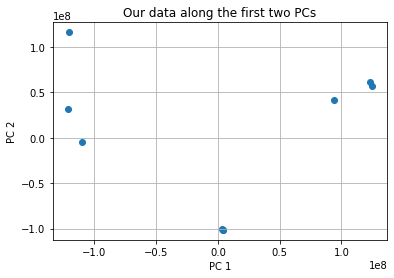

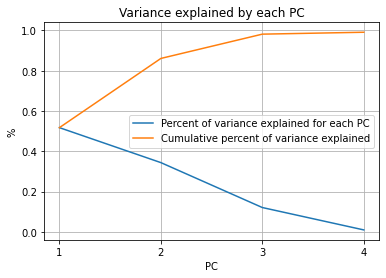

In [25]:
# So, as you know, the principle components of the data are the
# dimensions along which the data varies the most. The data
# here is 4 dimensional (since there are 4 features) and thus
# there are 4 total principle components.

# The first principle component will be the line along which the
# data varies the most. The second will be the line along with the
# data varies the second monst, and so on. The sum of the variances
# of all the principle components will be the entire variance of the
# dataset.

# Okay, so let's use the PCA function to get all 4 principle components.

# As always with the sklearn package, we first have to create and save
# a function "object":
pca = PCA(n_components=4)

# We can actually use this function object to get the first 4 principle
# components of any data. Let's do it for our data:
data_pca = pca.fit_transform(df)

# Now that we've called fit_transform, the pca object some attributes
# that includes the data points transformed along the principle components.
# So let's plot the data points along the first two principle components.
# We'll use the matplotlib.pyplot package to do this:
plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Our data along the first two PCs")
plt.grid(True)
plt.show()

# The explained variance is also included in the pca object.
# So we can plot that as well:
plt.plot(pca.explained_variance_ratio_,
        label="Percent of variance explained for each PC")
plt.plot([sum(pca.explained_variance_ratio_[:i]) for i in range(1, 5)],
        label="Cumulative percent of variance explained")
plt.legend()
plt.grid(True)
plt.xticks(range(4), ["%0.0f" % i for i in range(1, 5)])
plt.ylabel("%")
plt.xlabel("PC")
plt.title("Variance explained by each PC")
plt.show()

#make a plot where you zoom in
#volcano plots
# So now we see empirical evidence that the sum of all 4 variances
# equals the total variance in the data set (shown by the orange line) :)

Interactive PCA plots inspired from https://www.kaggle.com/maniyar2jaimin/interactive-plotly-guide-to-pca-lda-t-sne

In [44]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls

import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [26]:
df= pd.read_csv("results/Requant/FeatureMatrix_Rep_Flt.tsv", sep="\t")
target= df["mz"]
df= df.set_index(["RT","mz"])
df=df.transpose()
df

RT,347.190160,389.334750,394.970950,67.732574,388.712160,394.949250,392.770900,398.641240,411.639830,410.998800,...,398.542800,60.694800,400.690600,486.456300,408.428500,394.204130,344.235800,51.857147,381.444000,284.715270
mz,416.26373,1441.83850,966.61420,684.23645,705.91284,787.94190,1020.64510,1047.42020,1162.70860,719.92834,...,765.43390,1459.48020,843.45870,854.50420,841.43036,1000.85980,528.30240,1306.44290,831.91210,695.34174
DNPM_MDNA_WGS_14_rep1,136219.6,5.404403e+05,284705.50,124401.30,1686535.00,115049.20,413206.9,272859.30,183676.20,695653.4,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
DNPM_MDNA_WGS_14_rep2,144188.1,5.865534e+04,149096.80,32565.46,1109222.00,131840.90,266186.6,432108.10,131980.20,534247.3,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
DNPM_MDNA_WGS_14_rep3,121063.0,4.080058e+05,140170.00,28127.74,1095907.00,76413.18,284185.1,533610.70,166135.00,484984.5,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
FPY12_MDNA_WGS_14_rep1,365294.6,1.033793e+06,29289.28,932534.50,51761.03,349033.80,195431.9,274664.60,148731.60,487374.9,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
FPY12_MDNA_WGS_14_rep2,401567.7,5.176443e+06,247274.70,1040187.00,838351.30,7193028.00,2686807.0,7865175.00,3300304.00,4233446.0,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
FPY12_MDNA_WGS_14_rep3,378607.2,8.309144e+05,167386.00,938464.40,425031.60,1019574.00,2069697.0,2723863.00,25082.77,832676.8,...,0.0,0.00,0.000,0.0000,0.000,0.0,0.00,0.0,0.00,0.00
ISP2_MDNA_WGS_14_rep1,4458648.0,1.385736e+08,2119639.00,350064.90,1127549.00,2926994.00,9007209.0,643778.10,1717220.00,125526.4,...,328081.3,160504.40,14033.880,5852.0073,6678.139,243536.4,85088.88,0.0,0.00,0.00
ISP2_MDNA_WGS_14_rep2,2173351.0,1.165582e+08,2196827.00,323655.30,3159867.00,2162405.00,5904389.0,61621.45,1780021.00,1447890.0,...,0.0,0.00,8665.023,5480.1320,0.000,475040.1,67600.89,294773.2,498253.60,30148.16
ISP2_MDNA_WGS_14_rep3,3838263.0,1.418235e+08,3101566.00,296001.20,1367326.00,1515103.00,11157580.0,121747.20,1651051.00,118024.2,...,209927.5,85273.19,0.000,0.0000,6773.270,0.0,0.00,253851.0,62670.66,12862.43


In [49]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
X = df.values
X_std = StandardScaler().fit_transform(X)
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eigh(cov_mat) #ASK
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

In [50]:
trace1 = go.Scatter(
    x=list(range(10)),
    y= cum_var_exp,
    mode='lines+markers',
    hoverinfo= "all",
    name="'Cumulative Explained Variance'",
    line=dict(
        shape='spline',
        color = 'goldenrod'
    )
)
trace2 = go.Scatter(
    x=list(range(10)),
    y= var_exp,
    hoverinfo= "all",
    mode='lines+markers',
    name="'Individual Explained Variance'",
    line=dict(
        shape='linear',
        color = 'black'
    )
)
fig = tls.make_subplots(insets=[{'cell': (1,1), 'l': 0.7, 'b': 0.3}],
                          print_grid=True)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2,1,1)
fig.layout.xaxis = dict(range=[0, 9.5])
fig.layout.yaxis = dict(range=[0, 110])

py.iplot(fig, filename='inset example')

This is the format of your plot grid:
[ (1,1) x,y ]

With insets:
[ x2,y2 ] over [ (1,1) x,y ]



In [52]:
X= df.values

# Standardising the values
X_std = StandardScaler().fit_transform(X)

# Call the PCA method with 50 components. 
pca = PCA(n_components=5)
pca.fit(X_std)
X_5d = pca.transform(X_std)

# For cluster coloring in our Plotly plots, remember to also restrict the target values 
Target = target

In [53]:
trace0 = go.Scatter(
    x = X_5d[:,0],
    y = X_5d[:,1],
    name = "Target",
    hoverinfo = 'all',
    mode = 'markers',
#     text = Target.unique(),
    showlegend = False,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [trace0]

layout = dict(title = 'PCA (Principal Component Analysis)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= True
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

Create a matrix with all SIRIUS and CSI:FingerID formula and structural predictions, only choose #1 rankings predictions and combine the dataframes to annotate formula and structural predictions according to RT and mz:

In [25]:
import glob
import pandas as pd
import numpy as np
from functools import reduce
import copy

input_formulas = glob.glob('results/formulas/*.csv')
input_structures = glob.glob('results/structures/*.csv')

Dataframe with duplicate formulas (likely)

In [26]:
DF_SIRIUS= []
for i, formulas in enumerate(input_formulas):
    df= pd.read_csv(formulas, index_col="Unnamed: 0")
    df_rank= df.filter(regex=fr"opt_global_rank")
    df_score=df.filter(regex=fr"Score")
    df_opt=df.filter(regex=fr"opt")
    cols_score= df_score.columns
    cols_opt= df_opt.columns
    for i, row in df_rank.iterrows():
        if row.sum()>=2:
            df.loc[[i],row.index] = np.nan
    df= df.dropna()
    df= df.drop(columns=cols_score)
    df= df.drop(columns= cols_opt)
    df=df.reset_index()
    df= df.drop(columns="index")
    DF_SIRIUS.append(df)
    
df_formulas= pd.concat(DF_SIRIUS, axis=0).sort_values("chemical_formula")
df_formulas_helper= df_formulas.copy(deep=True)
df_formulas= df_formulas.set_index("chemical_formula")
df_formulas

,exp_mass_to_charge,retention_time
chemical_formula,,
C10H10N4O4,251.077489,176.203788
C10H10O2,180.101879,104.087659
C10H10O2,180.101881,101.885481
C10H11N4O2,237.123300,263.080686
C10H11NO2,195.112813,102.741705
...,...,...
C9H9N6O,235.118960,64.496458
C9H9NO2,181.097131,157.762375
C9H9NO2,181.097127,150.060453


Only the singletons:

In [27]:
df_singletons=df_formulas.reset_index().drop_duplicates(subset="chemical_formula", keep=False)
df_singletons= df_singletons.rename(columns={"chemical_formula": "formulas", "exp_mass_to_charge": "mz", "retention_time": "RT"})
df_singletons= df_singletons.set_index("formulas")
df_singletons

,mz,RT
formulas,,
C10H10N4O4,251.077489,176.203788
C10H11N4O2,237.123300,263.080686
C10H11NO6,259.092443,65.675430
C10H12N,169.085889,516.704356
C10H12N3O2,224.128145,59.713038
...,...,...
C9H7N4O,205.097117,279.260926
C9H7NO2,162.054953,250.272653
C9H8NO,164.093070,69.147407


Merge the mz and RT values of identical formulas if they have a delta(mz) 20ppm max and RT difference +-20 seconds:

In [131]:
from math import isclose

for key, values in enumerate(dict.values()):
    if len(values) == 2:
        mass_delta= (abs(values[0][0]-values[1][0])/values[0][0])*1000000.0
        maxdeltaRT= values[1][1]+20.0
        mindeltaRT= values[1][1]-20.0
        if (mindeltaRT <= values[0][1] <=  maxdeltaRT) &(mass_delta<= 20.0):
            values.pop()
    if len(values) > 2:
        x= len(values)-1
        a= values[0][0]
        A= values[0][1]
        for i, (b, B) in enumerate(zip([v[0] for v in values[1:]], [v[1] for v in values[1:]])):
            #print(i, b, B)
            mass_delta= (abs(a-b)/a)*1000000.0
            maxdeltaRT= A+20.0
            mindeltaRT= A-20.0
            if (mindeltaRT <= B <=  maxdeltaRT) &(mass_delta<= 20.0):
                del values[i] 
print(dict)

{'C10H10O2': [[180.101879031796, 104.08765896]], 'C10H11NO2': [[195.112813305145, 102.741704784]], 'C10H11NO3': [[211.107710317522, 109.954329328]], 'C10H12N2O': [[194.128852118112, 101.692306192]], 'C10H12N2O4': [[242.113555327239, 139.655391264]], 'C10H12O5': [[230.102162188825, 72.408255392]], 'C10H13N3O3': [[224.102977364025, 227.101249968]], 'C10H13NO2': [[180.101878000293, 318.33574976]], 'C10H13NO3': [[196.096805094733, 71.089349392]], 'C10H13NO3S': [[245.095466715257, 114.5727328]], 'C10H13NO4': [[229.118300709627, 49.174366432]], 'C10H14N2O2': [[195.11280638292, 266.913172656]], 'C10H14N2O3': [[228.134264398336, 235.484711568]], 'C10H14N2O4': [[209.092052291087, 194.941825696]], 'C10H15N9O': [[295.176489731198, 96.309271424]], 'C10H15NO': [[166.122598305451, 96.165865088]], 'C10H15NO2': [[182.117534532838, 184.023320048]], 'C10H15NO3': [[215.139010559911, 280.056415904]], 'C10H16N2O2': [[197.128527222724, 312.238379952]], 'C10H16N2O3': [[213.123356661111, 61.262744608]], 'C10H

Merge singletons with merged formulas to create a formula library:

In [132]:
df_formulas= pd.DataFrame(dict.items(), columns=['formulas', 'mz and RT'], index= None)

split_df = pd.DataFrame(df_formulas["mz and RT"].tolist(), columns = ["mz and RT"])
split_df = pd.DataFrame(split_df["mz and RT"].tolist(), columns = ['mz', 'RT'])

df = pd.concat([df_formulas, split_df], axis=1)
df= df.drop(columns=["mz and RT"])
df= df.set_index("formulas")
DF= pd.concat([df, df_singletons], axis=0)
DF_SIRIUS= DF.reset_index()
DF_SIRIUS.to_csv("results/formulas/ALL_SIRIUS_rank1.tsv", sep="\t", index= None)
DF_SIRIUS

,formulas,mz,RT
0,C10H10O2,180.101879,104.087659
1,C10H11NO2,195.112813,102.741705
2,C10H11NO3,211.107710,109.954329
3,C10H12N2O,194.128852,101.692306
4,C10H12N2O4,242.113555,139.655391
...,...,...,...
3367,C9H7N4O,205.097117,279.260926
3368,C9H7NO2,162.054953,250.272653
3369,C9H8NO,164.093070,69.147407
3370,C9H8NO2,180.087986,245.414881


Repeat for structral predictions (remove duplicates with the same inchi_keys, which means they represent the same structure):

In [133]:
DF_CSI= []
for i, formulas in enumerate(input_structures):
    df= pd.read_csv(formulas, index_col="Unnamed: 0")
    df_rank= df.filter(regex=fr"opt_global_rank")
    df_score=df.filter(regex=fr"best_search_engine_score")
    df_opt=df.filter(regex=fr"opt")
    cols_score= df_score.columns
    cols_opt= df_opt.columns
    for i, row in df_rank.iterrows():
        if row.sum()>=2:
            df.loc[[i],row.index] = np.nan
    df= df.dropna()
    df= df.drop(columns=cols_score)
    df= df.drop(columns= cols_opt)
    df= df.drop(columns= "identifier")
    df=df.reset_index()
    df= df.drop(columns="index")
    DF_CSI.append(df)


df_structures= pd.concat(DF_CSI, axis=0).sort_values("chemical_formula")
df_structures = df_structures.drop_duplicates(subset=['inchi_key'], keep='first')
df_structures= df_structures.drop(columns=["smiles", "inchi_key"])
df_structures_helper= df_structures.copy(deep=True)
df_structures= df_structures.set_index("chemical_formula")
df_structures

,description,exp_mass_to_charge,retention_time
chemical_formula,,,
C11H15N5O5S,"7,8-Dmtog",330.086771,64.281700
C11H21NO7S,Fructose methionine,312.111241,57.519373
C11H23NO3S3,8-(aminomethylsulfanyl)-6-(2-hydroxyethyldisul...,314.091916,211.124418
C12H14O2,4-(Methoxyphenyl)pent-3-en-2-one,208.133234,329.607460
C12H15N5O3S,"2-[4-amino-5-(3,4-dimethoxyphenyl)-1,2,4-triaz...",310.096937,223.754813
...,...,...,...
C48H76O18,"(2S,3S,4S,5R,6R)-6-[[(3S,6aR,6bS,8aS,14aR,14bR...",941.511301,524.621723
C48H78O19,3-O-[beta-Dglucopyranosyl-(1->2)-beta-D-galact...,959.521312,482.938059
C48H78O20,"(2S,3S,4S,5R,6R)-6-[[(3S,4aR,6aR,6bS,8R,8aR,9R...",975.516180,427.406652


Very few are different molecules with the same formula (most are singletons):

In [134]:
df_singletons=df_structures.reset_index().drop_duplicates(subset="chemical_formula", keep=False)
df_singletons= df_singletons.rename(columns={"chemical_formula": "formulas", "exp_mass_to_charge": "mz", "retention_time": "RT"})
df_singletons= df_singletons.set_index("formulas")
df_singletons

,description,mz,RT
formulas,,,
C11H15N5O5S,"7,8-Dmtog",330.086771,64.281700
C11H21NO7S,Fructose methionine,312.111241,57.519373
C11H23NO3S3,8-(aminomethylsulfanyl)-6-(2-hydroxyethyldisul...,314.091916,211.124418
C12H14O2,4-(Methoxyphenyl)pent-3-en-2-one,208.133234,329.607460
C12H15N5O3S,"2-[4-amino-5-(3,4-dimethoxyphenyl)-1,2,4-triaz...",310.096937,223.754813
...,...,...,...
C48H76O18,"(2S,3S,4S,5R,6R)-6-[[(3S,6aR,6bS,8aS,14aR,14bR...",941.511301,524.621723
C48H78O19,3-O-[beta-Dglucopyranosyl-(1->2)-beta-D-galact...,959.521312,482.938059
C48H78O20,"(2S,3S,4S,5R,6R)-6-[[(3S,4aR,6aR,6bS,8R,8aR,9R...",975.516180,427.406652


In [137]:
from itertools import chain
from collections import defaultdict

dict={}

for formula in np.unique(df_structures.index):
    if len(df_structures_helper[df_structures_helper["chemical_formula"]==formula])>=2:
        for i, lists in enumerate((df_structures_helper[df_structures_helper["chemical_formula"]==formula]).values.tolist()):
            key, value= lists[0], lists[1:]
            dict.setdefault(key, []).append(value)

from math import isclose

for key, values in enumerate(dict.values()):
    if len(values) == 2:
        mass_delta= (abs(values[0][1]-values[1][1])/values[0][1])*1000000.0
        maxdeltaRT= values[1][2]+20.0
        mindeltaRT= values[1][2]-20.0
        if (mindeltaRT <= values[0][2] <=  maxdeltaRT) &(mass_delta<= 20.0):
            values.pop()
    if len(values) > 2:
        x= len(values)-1
        a= values[0][1]
        A= values[0][2]
        for i, (b, B) in enumerate(zip([v[1] for v in values[1:]], [v[2] for v in values[1:]])):
            #print(i, b, B)
            mass_delta= (abs(a-b)/a)*1000000.0
            maxdeltaRT= A+20.0
            mindeltaRT= A-20.0
            if (mindeltaRT <= B <=  maxdeltaRT) &(mass_delta<= 20.0):
                del values[i] 
print(dict)

{'C14H27N3O5': [['2-[[2-[(2-amino-3-hydroxypropanoyl)amino]-4-methylpentanoyl]amino]-3-methylbutanoic acid', 318.202368179172, 180.203782656], ['L-leucyl-L-valyl-L-serine', 318.20238364061, 94.805491344]], 'C18H28O4': [['(E)-octadec-2-en-4-ynedioic acid', 309.20392382684, 501.396179024]], 'C19H32N2O3': [['1,5-dimethyl-3,7-dipentanoyl-3,7-diazabicyclo[3.3.1]nonan-9-one', 359.229108642016, 137.244507777], ['tert-Butyl [(1S,2R)-1-Benzyl-2-hydroxy-3-(isobutylamino)propyl]carbamate', 359.22902740929, 272.151533344]], 'C20H28N6O3': [['Cdk2 Inhibitor III', 423.212795661786, 283.607808769], ['2-(4-Cyclopentylcarbamoylpiperazin-1-yl)-4-amino-6,7-dimethoxyquinazoline', 401.228418848335, 321.09289824]], 'C20H30N6O4': [['Phenylalanyl-prolyl-arginine', 441.22349384307, 309.693065776], ['L-Arginine, L-prolyl-L-phenylalanyl-', 441.223452133934, 283.607808769]], 'C21H24N2O7': [['methyl tetrahydrofuran-2-ylmethyl 2,6-dimethyl-4-(3-nitrophenyl)-1,4-dihydropyridine-3,5-dicarboxylate', 417.166967207266, 7

In [145]:
df_structures= pd.DataFrame(dict.items(), columns=['formulas', 'descriptions, mz and RT'], index= None)
split_df = pd.DataFrame(df_structures["descriptions, mz and RT"].tolist(), columns = ['list1', 'list2'])
split_df_1 = pd.DataFrame(split_df['list1'].tolist(), columns = ['description', 'mz', 'RT'])
df_1 = pd.concat([df_structures, split_df_1], axis=1)
df_1= df_1.drop(columns='descriptions, mz and RT')
split_df_2= split_df['list2']
df_2= pd.concat([df_structures, split_df_2], axis=1)
df_2= df_2.drop(columns='descriptions, mz and RT')
df_2= df_2.dropna()
df_2=df_2.reset_index().drop(columns="index")
split_df_2 = pd.DataFrame(df_2['list2'].tolist(), columns = ['description_0', 'mz_0', 'RT_0'])
DF_2= pd.concat([df_2, split_df_2], axis=1)
DF_2= DF_2.drop(columns= "list2")
DF= pd.merge(DF_2, df_1, on= "formulas", how= "outer")
df_singletons= df_singletons.reset_index()
DF_CSI= pd.merge(DF, df_singletons, on= ["formulas", "description", "mz", "RT"], how= "outer")
DF_CSI.to_csv("results/annotations/ALL_CSI_rank1.tsv", sep="\t", index= None)
DF_CSI

,formulas,description_0,mz_0,RT_0,description,mz,RT,index
0,C14H27N3O5,L-leucyl-L-valyl-L-serine,318.202384,94.805491,2-[[2-[(2-amino-3-hydroxypropanoyl)amino]-4-me...,318.202368,180.203783,NaN
1,C19H32N2O3,"tert-Butyl [(1S,2R)-1-Benzyl-2-hydroxy-3-(isob...",359.229027,272.151533,"1,5-dimethyl-3,7-dipentanoyl-3,7-diazabicyclo[...",359.229109,137.244508,NaN
2,C20H28N6O3,2-(4-Cyclopentylcarbamoylpiperazin-1-yl)-4-ami...,401.228419,321.092898,Cdk2 Inhibitor III,423.212796,283.607809,NaN
3,C20H30N6O4,"L-Arginine, L-prolyl-L-phenylalanyl-",441.223452,283.607809,Phenylalanyl-prolyl-arginine,441.223494,309.693066,NaN
4,C22H31N3O5,Cinepazida,440.213173,175.382467,"(2S)-2-[[(2S)-1-[(2S,3S)-2-acetamido-3-methylp...",440.212949,219.790488,NaN
...,...,...,...,...,...,...,...,...
402,C48H76O18,NaN,NaN,NaN,"(2S,3S,4S,5R,6R)-6-[[(3S,6aR,6bS,8aS,14aR,14bR...",941.511301,524.621723,393.0
403,C48H78O19,NaN,NaN,NaN,3-O-[beta-Dglucopyranosyl-(1->2)-beta-D-galact...,959.521312,482.938059,394.0
404,C48H78O20,NaN,NaN,NaN,"(2S,3S,4S,5R,6R)-6-[[(3S,4aR,6aR,6bS,8R,8aR,9R...",975.516180,427.406652,395.0
405,C51H80O15,NaN,NaN,NaN,"Digalactosyldiacylglycerol(18:4(6Z,9Z,12Z,15Z)...",933.557975,424.590454,396.0


Annotate the formulas and structural predictions to the feature matrix according to SIRIUS and CSI:

In [139]:
df= pd.read_csv("results/Requant/FeatureMatrix_Rep_Flt.tsv", sep="\t")
df

,RT,mz,DNPM_MDNA_WGS_14_rep1,DNPM_MDNA_WGS_14_rep2,DNPM_MDNA_WGS_14_rep3,FPY12_MDNA_WGS_14_rep1,FPY12_MDNA_WGS_14_rep2,FPY12_MDNA_WGS_14_rep3,ISP2_MDNA_WGS_14_rep1,ISP2_MDNA_WGS_14_rep2,ISP2_MDNA_WGS_14_rep3
0,347.190160,416.26373,136219.6,144188.10,121063.00,365294.60,401567.7,378607.2,4.458648e+06,2.173351e+06,3.838263e+06
1,389.334750,1441.83850,540440.3,58655.34,408005.80,1033793.00,5176443.0,830914.4,1.385736e+08,1.165582e+08,1.418235e+08
2,394.970950,966.61420,284705.5,149096.80,140170.00,29289.28,247274.7,167386.0,2.119639e+06,2.196827e+06,3.101566e+06
3,67.732574,684.23645,124401.3,32565.46,28127.74,932534.50,1040187.0,938464.4,3.500649e+05,3.236553e+05,2.960012e+05
4,388.712160,705.91284,1686535.0,1109222.00,1095907.00,51761.03,838351.3,425031.6,1.127549e+06,3.159867e+06,1.367326e+06
...,...,...,...,...,...,...,...,...,...,...,...
1194,394.204130,1000.85980,0.0,0.00,0.00,0.00,0.0,0.0,2.435364e+05,4.750401e+05,0.000000e+00
1195,344.235800,528.30240,0.0,0.00,0.00,0.00,0.0,0.0,8.508888e+04,6.760089e+04,0.000000e+00
1196,51.857147,1306.44290,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,2.947732e+05,2.538510e+05
1197,381.444000,831.91210,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,4.982536e+05,6.267066e+04


In [147]:
df.insert(0, 'CSI_predictions', '')

for i, mz, rt in zip(df.index, df['mz'], df['RT']):
    hits = []
    for name, Pred_mz, Pred_rt, in zip(DF_CSI['description'], DF_CSI['mz'], DF_CSI['RT']):
        mass_delta = (abs(Pred_mz-mz)/Pred_mz)*1000000.0 if Pred_mz != 0 else 0
        if (Pred_rt >= rt-20.0) & (Pred_rt <= rt+20.0) & (mass_delta<= 20.0):
            hit = f'{name}'
            if hit not in hits:
                hits.append(hit)
    df['CSI_predictions'][i] = ' ## '.join(hits)

df

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_29623/1433750724.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CSI_predictions'][i] = ' ## '.join(hits)


,SIRIUS_predictions,CSI_predictions,RT,mz,DNPM_MDNA_WGS_14_rep1,DNPM_MDNA_WGS_14_rep2,DNPM_MDNA_WGS_14_rep3,FPY12_MDNA_WGS_14_rep1,FPY12_MDNA_WGS_14_rep2,FPY12_MDNA_WGS_14_rep3,ISP2_MDNA_WGS_14_rep1,ISP2_MDNA_WGS_14_rep2,ISP2_MDNA_WGS_14_rep3
0,C19H41NO8 ## C21H37NO7,,347.190160,416.26373,136219.6,144188.10,121063.00,365294.60,401567.7,378607.2,4.458648e+06,2.173351e+06,3.838263e+06
1,C79H114N10O16,,389.334750,1441.83850,540440.3,58655.34,408005.80,1033793.00,5176443.0,830914.4,1.385736e+08,1.165582e+08,1.418235e+08
2,,,394.970950,966.61420,284705.5,149096.80,140170.00,29289.28,247274.7,167386.0,2.119639e+06,2.196827e+06,3.101566e+06
3,,,67.732574,684.23645,124401.3,32565.46,28127.74,932534.50,1040187.0,938464.4,3.500649e+05,3.236553e+05,2.960012e+05
4,,,388.712160,705.91284,1686535.0,1109222.00,1095907.00,51761.03,838351.3,425031.6,1.127549e+06,3.159867e+06,1.367326e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,,,394.204130,1000.85980,0.0,0.00,0.00,0.00,0.0,0.0,2.435364e+05,4.750401e+05,0.000000e+00
1195,,,344.235800,528.30240,0.0,0.00,0.00,0.00,0.0,0.0,8.508888e+04,6.760089e+04,0.000000e+00
1196,,,51.857147,1306.44290,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,2.947732e+05,2.538510e+05
1197,,,381.444000,831.91210,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,4.982536e+05,6.267066e+04


In [141]:
for i, mz, rt in zip(df.index, df['mz'], df['RT']):
    hits = []
    for name, Pred_mz, Pred_rt, in zip(DF_CSI['description_0'], DF_CSI['mz_0'], DF_CSI['RT_0']):
        mass_delta = (abs(Pred_mz-mz)/Pred_mz)*1000000.0 if Pred_mz != 0 else 0
        if (Pred_rt >= rt-20.0) & (Pred_rt <= rt+20.0) & (mass_delta<= 20.0):
            hit = f'{name}'
            if hit not in hits:
                hits.append(hit)
    df['CSI_predictions'][i] = ' ## '.join(hits)

df

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_29623/771930109.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CSI_predictions'][i] = ' ## '.join(hits)


,CSI_predictions,RT,mz,DNPM_MDNA_WGS_14_rep1,DNPM_MDNA_WGS_14_rep2,DNPM_MDNA_WGS_14_rep3,FPY12_MDNA_WGS_14_rep1,FPY12_MDNA_WGS_14_rep2,FPY12_MDNA_WGS_14_rep3,ISP2_MDNA_WGS_14_rep1,ISP2_MDNA_WGS_14_rep2,ISP2_MDNA_WGS_14_rep3
0,,347.190160,416.26373,136219.6,144188.10,121063.00,365294.60,401567.7,378607.2,4.458648e+06,2.173351e+06,3.838263e+06
1,,389.334750,1441.83850,540440.3,58655.34,408005.80,1033793.00,5176443.0,830914.4,1.385736e+08,1.165582e+08,1.418235e+08
2,,394.970950,966.61420,284705.5,149096.80,140170.00,29289.28,247274.7,167386.0,2.119639e+06,2.196827e+06,3.101566e+06
3,,67.732574,684.23645,124401.3,32565.46,28127.74,932534.50,1040187.0,938464.4,3.500649e+05,3.236553e+05,2.960012e+05
4,,388.712160,705.91284,1686535.0,1109222.00,1095907.00,51761.03,838351.3,425031.6,1.127549e+06,3.159867e+06,1.367326e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
1194,,394.204130,1000.85980,0.0,0.00,0.00,0.00,0.0,0.0,2.435364e+05,4.750401e+05,0.000000e+00
1195,,344.235800,528.30240,0.0,0.00,0.00,0.00,0.0,0.0,8.508888e+04,6.760089e+04,0.000000e+00
1196,,51.857147,1306.44290,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,2.947732e+05,2.538510e+05
1197,,381.444000,831.91210,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,4.982536e+05,6.267066e+04


In [142]:
df.insert(0, 'SIRIUS_predictions', '')

for i, mz, rt in zip(df.index, df['mz'], df['RT']):
    hits = []
    for name, Pred_mz, Pred_rt, in zip(DF_SIRIUS['formulas'], DF_SIRIUS['mz'], DF_SIRIUS['RT']):
        mass_delta = (abs(Pred_mz-mz)/Pred_mz)*1000000.0 if Pred_mz != 0 else 0
        if (Pred_rt >= rt-20.0) & (Pred_rt <= rt+20.0) & (mass_delta<= 20.0):
            hit = f'{name}'
            if hit not in hits:
                hits.append(hit)
    df['SIRIUS_predictions'][i] = ' ## '.join(hits)
df

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_29623/4227875185.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SIRIUS_predictions'][i] = ' ## '.join(hits)


,SIRIUS_predictions,CSI_predictions,RT,mz,DNPM_MDNA_WGS_14_rep1,DNPM_MDNA_WGS_14_rep2,DNPM_MDNA_WGS_14_rep3,FPY12_MDNA_WGS_14_rep1,FPY12_MDNA_WGS_14_rep2,FPY12_MDNA_WGS_14_rep3,ISP2_MDNA_WGS_14_rep1,ISP2_MDNA_WGS_14_rep2,ISP2_MDNA_WGS_14_rep3
0,C19H41NO8 ## C21H37NO7,,347.190160,416.26373,136219.6,144188.10,121063.00,365294.60,401567.7,378607.2,4.458648e+06,2.173351e+06,3.838263e+06
1,C79H114N10O16,,389.334750,1441.83850,540440.3,58655.34,408005.80,1033793.00,5176443.0,830914.4,1.385736e+08,1.165582e+08,1.418235e+08
2,,,394.970950,966.61420,284705.5,149096.80,140170.00,29289.28,247274.7,167386.0,2.119639e+06,2.196827e+06,3.101566e+06
3,,,67.732574,684.23645,124401.3,32565.46,28127.74,932534.50,1040187.0,938464.4,3.500649e+05,3.236553e+05,2.960012e+05
4,,,388.712160,705.91284,1686535.0,1109222.00,1095907.00,51761.03,838351.3,425031.6,1.127549e+06,3.159867e+06,1.367326e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,,,394.204130,1000.85980,0.0,0.00,0.00,0.00,0.0,0.0,2.435364e+05,4.750401e+05,0.000000e+00
1195,,,344.235800,528.30240,0.0,0.00,0.00,0.00,0.0,0.0,8.508888e+04,6.760089e+04,0.000000e+00
1196,,,51.857147,1306.44290,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,2.947732e+05,2.538510e+05
1197,,,381.444000,831.91210,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,4.982536e+05,6.267066e+04


In [148]:
df.to_csv("results/annotations/FeatureMatrix_SIRIUS.tsv", sep="\t", index= None)